<a href="https://colab.research.google.com/github/Dimdim666-trk/TI-1C/blob/main/Regresi_Gambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# D1

Regresi dari Citra Sintetis

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models

# Generator 1 sample
def make_sample(img_size=64, min_r=5, max_r=20):
  r = np.random.randint(min_r, max_r + 1) # radius acak
  img = np.zeros((img_size, img_size), dtype=np.uint8)
  cx = np.random.randint(r, img_size - r) # center-x
  cy = np.random.randint(r, img_size - r) # center-y
  cv2.circle(img, (cx, cy), r, (255,), -1) # lingkaran putih terisi
  img = (img / 255.0).astype(np.float32)
  # 3-channel biar kompatibel CNN
  img3 = np.stack([img, img, img], axis=-1)
  return img3, float(r), (cx, cy)


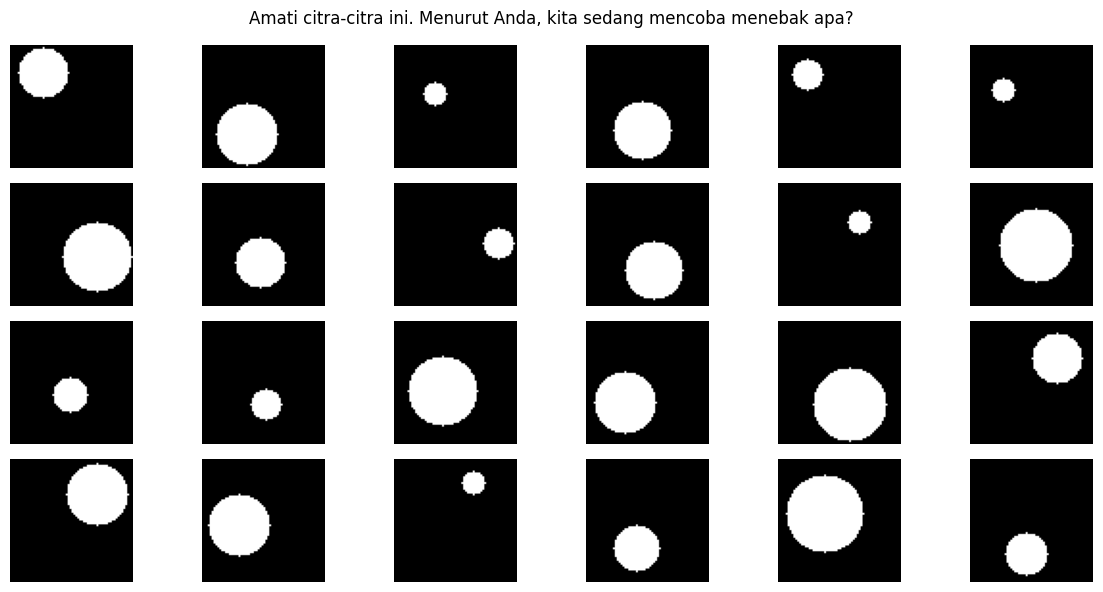

In [16]:
# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range (N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

# Grid gambar tanpa label:
cols = 6
rows = N_show // cols
plt.figure(figsize=(12, 6))
for i in range(N_show):
  plt.subplot(rows, cols, i+1)
  plt.imshow(imgs[i].squeeze(), cmap='gray')
  plt.axis('off')
plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?")
plt.tight_layout()
plt.show()


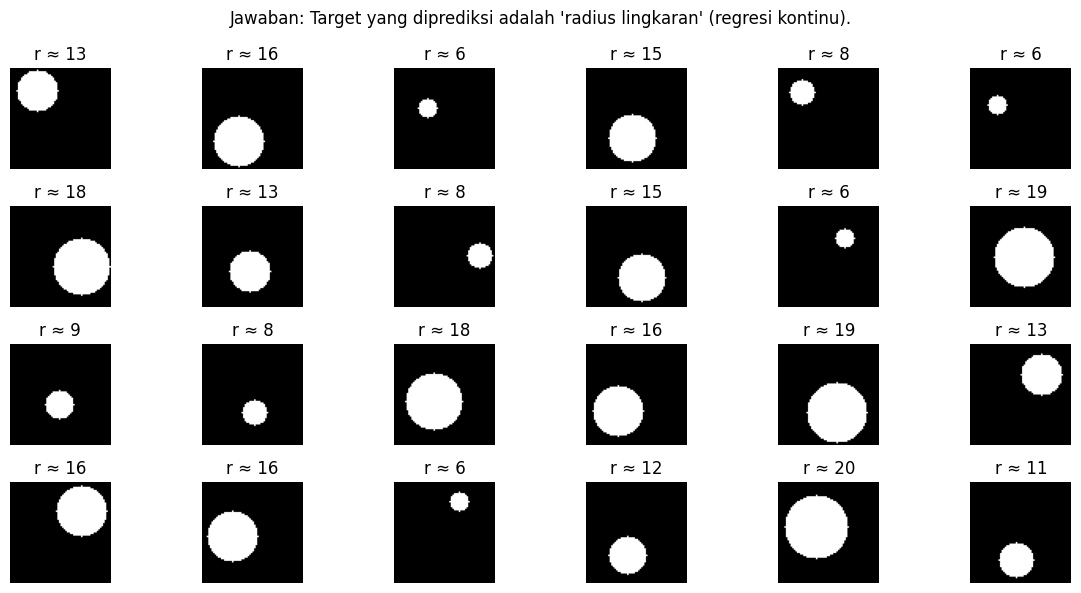

In [46]:
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))
for i in range(N_show):
  plt.subplot(rows, cols, i+1)
  plt.imshow(imgs[i].squeeze(), cmap='gray')
  plt.title(f"r ≈ {int(rads[i])}")
  plt.axis('off')
plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).")
plt.tight_layout()
plt.show()


Model CNN

In [44]:
# Siapkan dataset lebih besar untuk training N = 3000
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

# Bagi dataset menjadi train dan test
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
    layers.Input((64, 64, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Output regresi
])

# Kompilasi dan training model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(
    Xtr, ytr,
    validation_data=(Xte, yte),
    epochs=12,
    batch_size=64,
    verbose=0
)

# Evaluasi performa model
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred) ** 2)))
r2 = r2_score(yte, y_pred)

print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
MAE=0.957 | RMSE=1.161 | R²=0.933


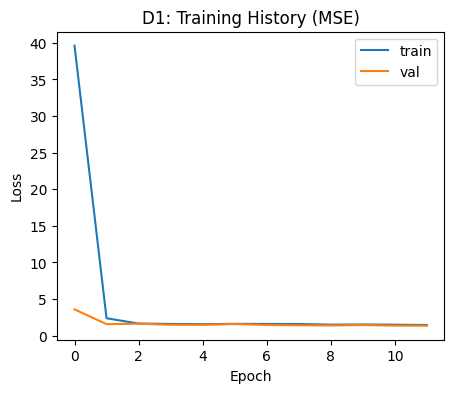

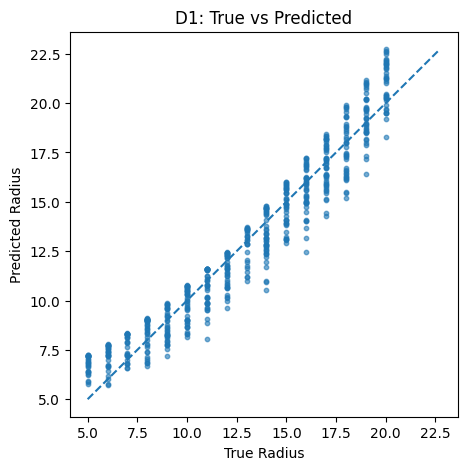

In [45]:
# Plot loss
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()
# Scatter True vs Pred
plt.figure(figsize=(5,5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius"); plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()


# D2

Unggah kaggle.json

In [17]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"adiladimazbuwana","key":"b688c7688a063f799f16f8bbfe356e48"}'}

Siapkan Koneksi

In [18]:
import os, shutil
if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print(" .ı kaggle.json belum ditemukan. Upload terlebih dahulu.")

✅ Kaggle API siap digunakan.


Unduh Dataset

In [22]:
# Unduh dataset UTKFace (sekali saja)
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil diekstrak.")

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
replace /content/utk/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
replace /content/utk/UTKFace/100_0_0_20170112215240346.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ✅ Dataset UTKFace berhasil diekstrak.


Tampilkan Gambar

Total gambar ditemukan: 23708


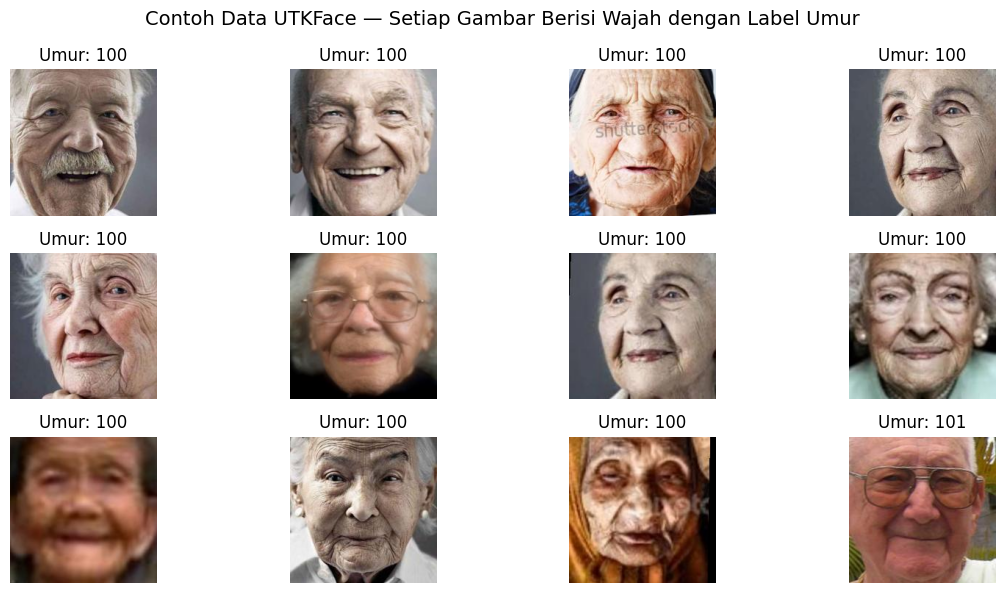

In [20]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

# Ambil 12 gambar acak dari dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")
plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]): # Ambil umur dari nama file
  age = int(os.path.basename(f).split("_")[0])
  img = Image.open(f)
  plt.subplot(3, 4, i + 1)
  plt.imshow(img)
  plt.title(f"Umur: {age}")
  plt.axis("off")
plt.suptitle("Contoh Data UTKFace — Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
plt.tight_layout()
plt.show()


Siapkan Dataset

In [24]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def parse_age_from_name(fp):
  return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, test_files, y_train, y_test = train_test_split(
  files, ages, test_size=0.2, random_state=42
)

IMG_SIZE = 160
def load_img(fp, label):
  img = tf.io.read_file(fp)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
  return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)).map(load_img).batch(64)

print("✅ Dataset siap dilatih.")


✅ Dataset siap dilatih.


Membangun Model

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")
# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2( include_top=False,
input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet'
)
base_model.trainable = False # tahap awal: freeze backbone
# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x) # output tunggal: umur
model = tf.keras.Model(inputs, outputs)
# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss='mse', metrics=['mae'])

model.summary()

Hardware: GPU


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Melatih Model

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 39s 92ms/step - loss: 332.2324 - mae: 13.4139 - val_loss: 157.9897 - val_mae: 9.5353 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - loss: 154.5428 - mae: 9.2043 - val_loss: 145.3536 - val_mae: 9.0253 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - loss: 144.3454 - mae: 8.8478 - val_loss: 141.1705 - val_mae: 8.8146 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - loss: 141.8631 - mae: 8.7612 - val_loss: 139.6749 - val_mae: 8.7797 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - loss: 137.8646 - mae: 8.5898 - val_loss: 139.3176 - val_mae: 8.7849 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - loss: 136.8177 - mae: 8.5502 - val_loss: 136.5130 - val_mae: 8.6162 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - loss: 135.3111 - mae: 8.4858 - val_loss: 135.7304 - val

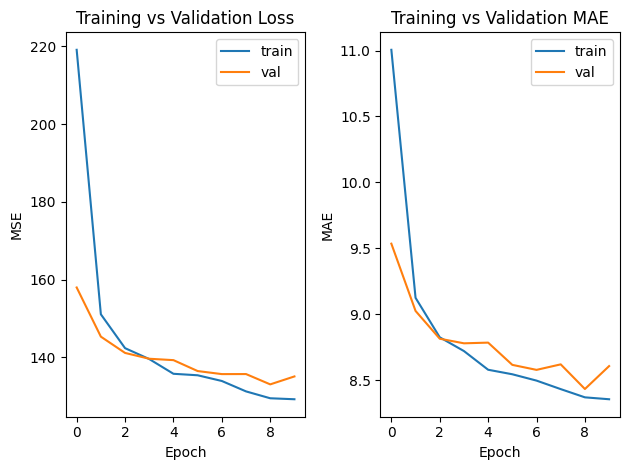

In [26]:
# Callback untuk pelatihan yang lebih stabil
cb = [
  tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),

  tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')
]

history = model.fit( train_ds, validation_data=test_ds, epochs=10,
callbacks=cb, verbose=1
)

# Visualisasi perubahan loss dan MAE selama pelatihan: plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.tight_layout()
plt.show()

Fine Tuning

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 59s 156ms/step - loss: 128.4068 - mae: 8.3123 - val_loss: 131.7599 - val_mae: 8.3607 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - loss: 126.3293 - mae: 8.2209 - val_loss: 131.8817 - val_mae: 8.4071 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 127.6519 - mae: 8.3004 - val_loss: 131.4138 - val_mae: 8.3356 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 127.3249 - mae: 8.2311 - val_loss: 131.2267 - val_mae: 8.3449 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 126.5020 - mae: 8.2081 - val_loss: 131.4926 - val_mae: 8.3893 - learning_rate: 1.0000e-04


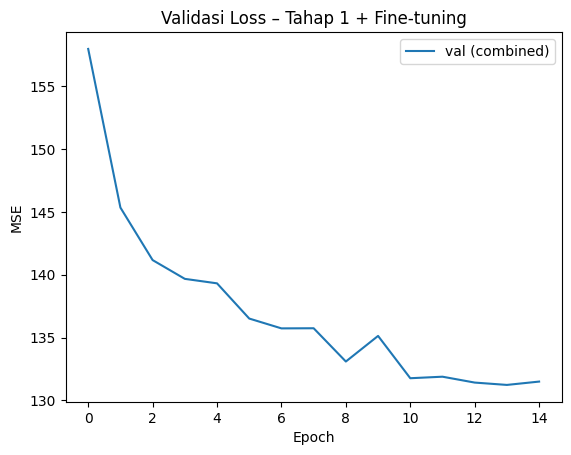

In [27]:
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning base_model.trainable = True
for layer in base_model.layers[:-30]:
  layer.trainable = False # beku sebagian besar layer

# Recompile dengan learning rate lebih kecil
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
  loss='mse', metrics=['mae'])
history_ft = model.fit( train_ds, validation_data=test_ds, epochs=5,
callbacks=cb, verbose=1
)

# Visualisasi gabungan training dan fine-tuning:
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='val (combined)')
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

Evaluasi Akhir

MAE = 8.34 tahun
RMSE = 11.46 tahun
R²	= 0.669


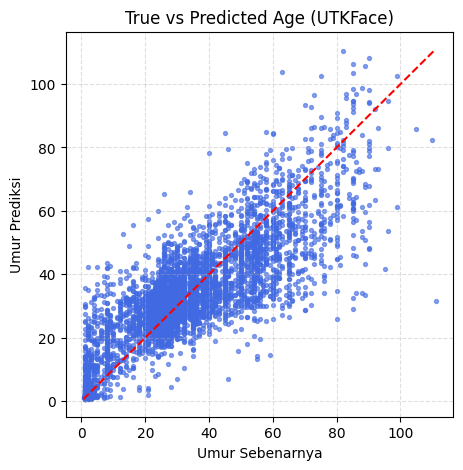

In [28]:
from math import sqrt

y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in test_ds])
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)
print(f"MAE = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R²	= {r2:.3f}")

# Plot “umur sebenarnya vs umur prediksi”:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


Prediksi Nyata

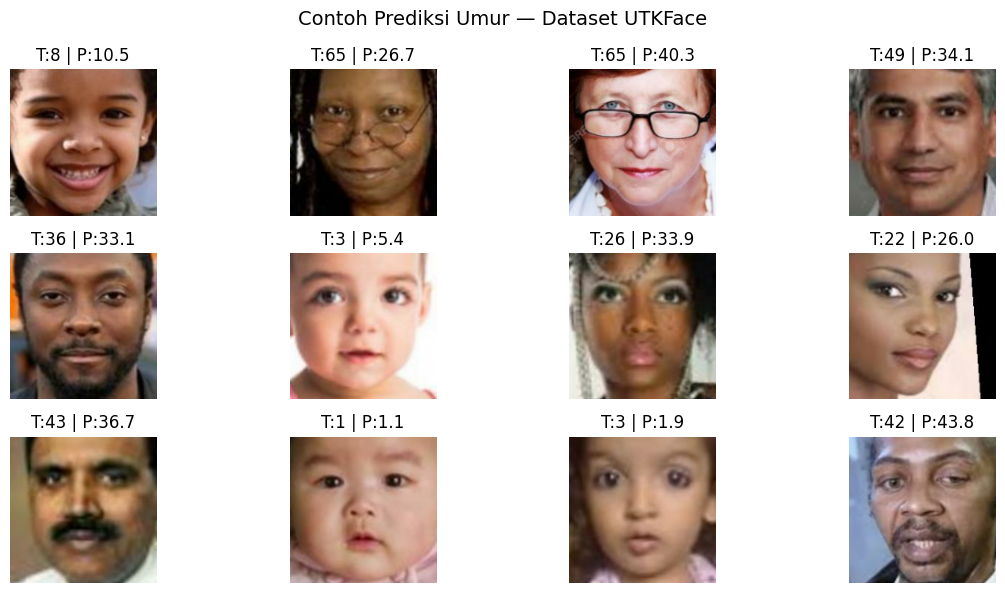

In [29]:
import random
sample_paths = random.sample(test_files, 12)
plt.figure(figsize=(12,6))
for i, path in enumerate(sample_paths):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
  true_age = int(os.path.basename(path).split('_')[0])
  pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
  plt.subplot(3,4,i+1)
  plt.imshow(img.numpy())
  plt.title(f"T:{true_age} | P:{pred_age:.1f}")
  plt.axis('off')
plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()

# D3

In [30]:
from google.colab import files
files.upload() # pilih kaggle.json dari komputer Anda
import os, shutil
if os.path.exists("kaggle.json"):
  os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
  shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
  os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
  !pip -q install kaggle
  print("✅ Kaggle API siap digunakan.")
else:
  print(" ı. kaggle.json belum ditemukan. Upload terlebih dahulu.")

Saving kaggle.json to kaggle (3).json
✅ Kaggle API siap digunakan.


Unduh Dataset

In [31]:
# Unduh dataset Pawpularity (sekitar 800MB)
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
print("✅ Dataset Pawpularity berhasil diekstrak.")

✅ Dataset Pawpularity berhasil diekstrak.


Melihat Data

                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

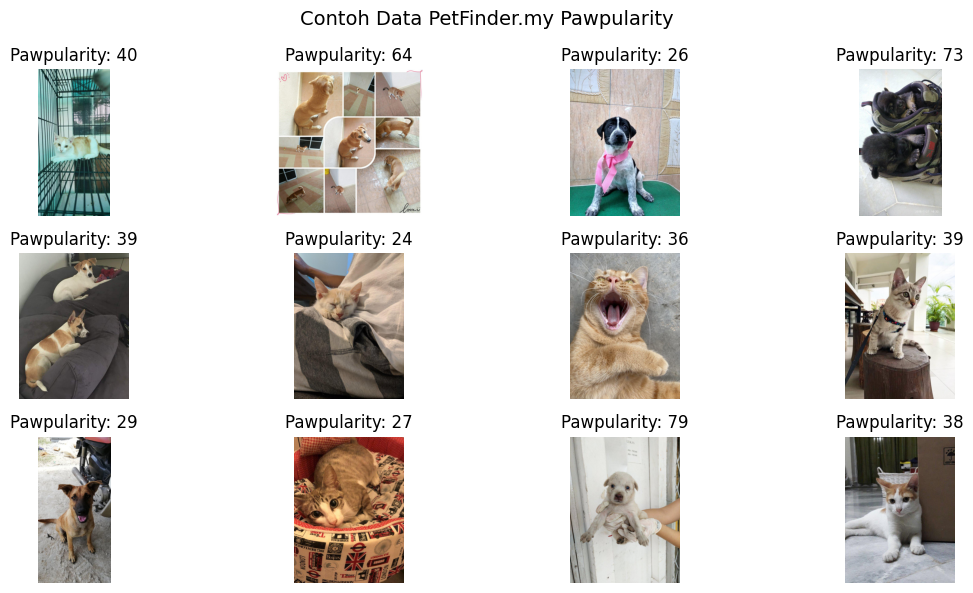

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Muat CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())

# Tampilkan 12 contoh gambar
plt.figure(figsize=(12, 6))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
  img = Image.open(row.path)
  plt.subplot(3, 4, i + 1)
  plt.imshow(img)
  plt.title(f"Pawpularity: {row.Pawpularity}")
  plt.axis('off')
plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

Persiapan Dataset

In [33]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
IMG_SIZE = 224
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

def load_image(path, label):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
  img = tf.cast(img, tf.float32) / 255.0
  return img, tf.cast(label, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'],
train_df['Pawpularity']))\
.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
.shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'],
val_df['Pawpularity']))\
  .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
  .batch(64).prefetch(tf.data.AUTOTUNE)

print(f"Dataset siap digunakan — {len(train_df)} untuk training,{len(val_df)} untuk validasi.")


Dataset siap digunakan — 7929 untuk training,1983 untuk validasi.


Membangun Model

In [34]:
from tensorflow.keras import layers, models
base = tf.keras.applications.EfficientNetB0( include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet'
)
base.trainable = False # freeze sementara

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_2 (Multiply)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Melatih Model

In [35]:
cb = [
tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=cb, verbose=1)


Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 115s 519ms/step - loss: 868.9987 - mae: 22.3602 - val_loss: 483.9645 - val_mae: 16.3295 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 85s 206ms/step - loss: 432.4133 - mae: 15.2739 - val_loss: 431.2119 - val_mae: 15.5142 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 43s 227ms/step - loss: 402.7359 - mae: 14.9270 - val_loss: 403.7539 - val_mae: 14.9060 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - loss: 378.8452 - mae: 14.4892 - val_loss: 388.6319 - val_mae: 14.5663 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 78s 199ms/step - loss: 342.9199 - mae: 13.7535 - val_loss: 377.5848 - val_mae: 14.3453 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 40s 227ms/step - loss: 351.0402 - mae: 13.9419 - val_loss: 371.8221 - val_mae: 14.2261 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 45s 265ms/step - loss: 348.1143 - mae: 13.9548 - val_

Melatih Proses Belajar

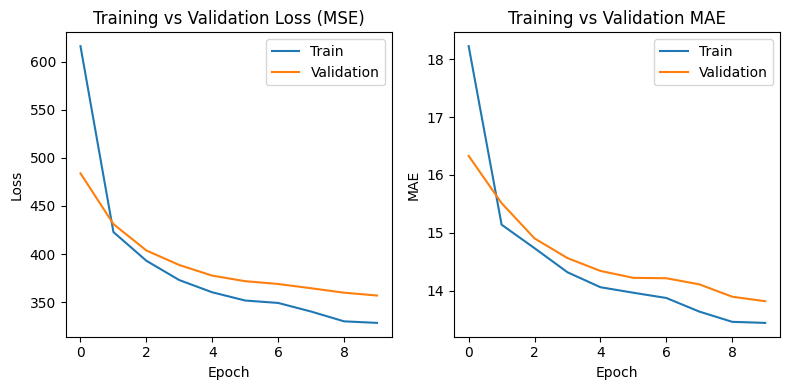

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend()
plt.tight_layout()
plt.show()


Evaluasi Model

MAE = 13.82
RMSE = 18.89
R²	= 0.193


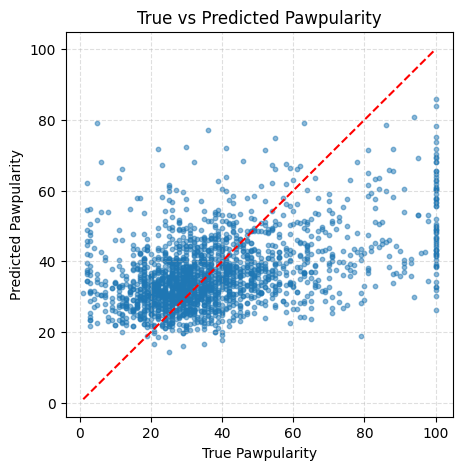

In [37]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for
batch in val_ds])

mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)

print(f"MAE = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²	= {r2:.3f}")

# Plot hasil prediksi vs nilai sebenarnya:
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


Melihat Prediksi

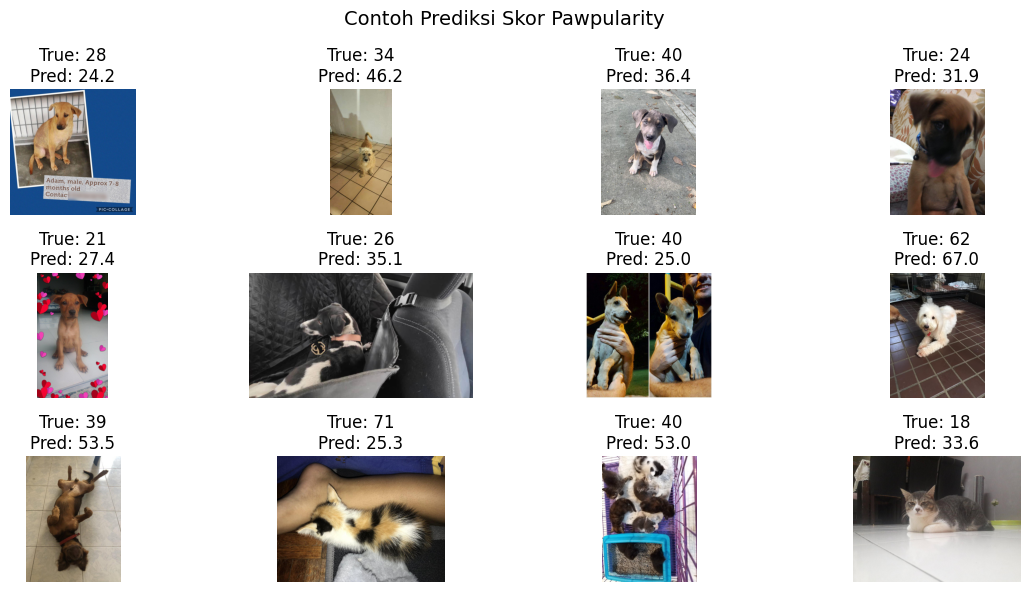

In [38]:
import random
from PIL import Image

sample_rows = val_df.sample(12, random_state=1)

plt.figure(figsize=(12,6))
for i, row in enumerate(sample_rows.itertuples()):
  img = Image.open(row.path)
  pred = model.predict(tf.expand_dims(load_image(row.path,
row.Pawpularity)[0], 0), verbose=0).ravel()[0]
  plt.subplot(3,4,i+1)
  plt.imshow(img)
  plt.title(f"True: {row.Pawpularity}\nPred: {pred:.1f}")
  plt.axis('off')
plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()


In [39]:
# Tantangan 1: Tambahkan data augmentation agar model tidak bosan dengan pola yang sama
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, r2_score

# Pastikan variabel val_df, val_ds, train_df, load_image, IMG_SIZE sudah ada dari D3 utama

# Fungsi augmentasi gambar
def augment_image(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    img = tf.image.random_saturation(img, lower=0.8, upper=1.2)
    img = tf.image.resize_with_crop_or_pad(img, IMG_SIZE + 20, IMG_SIZE + 20)
    img = tf.image.random_crop(img, size=[IMG_SIZE, IMG_SIZE, 3])
    return img, label


# Dataset training dengan augmentasi
train_aug = (
    tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity']))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(4096)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

# Gunakan model EfficientNetB0 seperti sebelumnya
base_aug = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_aug.trainable = False

# Bangun model
inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base_aug(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model_aug = tf.keras.Model(inputs, outputs)
model_aug.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Callback
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

# Training model
history_aug = model_aug.fit(
    train_aug,
    validation_data=val_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# Evaluasi
y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([
    model_aug.predict(batch[0], verbose=0).ravel() for batch in val_ds
])
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
r2 = r2_score(y_true, y_pred)

print(f"(Augmented) MAE={mae:.2f} | RMSE={rmse:.2f} | R²={r2:.3f}")


Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 93s 453ms/step - loss: 791.5465 - mae: 21.3539 - val_loss: 482.9467 - val_mae: 16.3170 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 50s 267ms/step - loss: 422.8058 - mae: 15.2886 - val_loss: 431.2252 - val_mae: 15.5326 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 81s 266ms/step - loss: 398.0254 - mae: 14.8354 - val_loss: 404.8234 - val_mae: 14.8055 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 54s 273ms/step - loss: 386.1222 - mae: 14.5395 - val_loss: 388.6127 - val_mae: 14.5814 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 47s 235ms/step - loss: 364.8947 - mae: 14.2196 - val_loss: 379.7965 - val_mae: 14.3986 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 46s 241ms/step - loss: 362.0121 - mae: 13.9839 - val_loss: 372.1237 - val_mae: 14.2290 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 79s 222ms/step - loss: 348.9666 - mae: 13.8458 - val_l

In [40]:
# Tantangan 2: Ganti model dengan EfficientNetB3 / ResNet50
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score

# Gunakan model yang lebih besar: EfficientNetB3
base_b3 = tf.keras.applications.EfficientNetB3(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_b3.trainable = False

# Bangun arsitektur model
inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base_b3(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model_b3 = tf.keras.Model(inputs, outputs)
model_b3.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Callback
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

# Training model
history_b3 = model_b3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    callbacks=cb,
    verbose=1
)

# Evaluasi performa model
y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred_b3 = np.concatenate([
    model_b3.predict(batch[0], verbose=0).ravel() for batch in val_ds
])
mae = mean_absolute_error(y_true, y_pred_b3)
rmse = np.sqrt(np.mean((y_true - y_pred_b3) ** 2))
r2 = r2_score(y_true, y_pred_b3)

print(f"(EfficientNetB3) MAE={mae:.2f} | RMSE={rmse:.2f} | R²={r2:.3f}")


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 149s 727ms/step - loss: 865.1218 - mae: 22.2836 - val_loss: 481.8173 - val_mae: 16.0595 - learning_rate: 0.0010
Epoch 2/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 42s 228ms/step - loss: 453.6966 - mae: 15.7159 - val_loss: 418.0916 - val_mae: 15.1142 - learning_rate: 0.0010
Epoch 3/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 46s 263ms/step - loss: 393.5673 - mae: 14.6220 - val_loss: 394.6093 - val_mae: 14.8515 - learning_rate: 0.0010
Epoch 4/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 51s 289ms/step - loss: 381.5400 - mae: 14.5949 - val_loss: 378.8633 - val_mae: 14.2856 - learning_rate: 0.0010
Epoch 5/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 50s 269ms/step - loss: 352.4492 - mae: 14.0087 - val_loss: 370.2679 - val_mae: 14.2015 - learning_rate: 0.0010
Epoch 6/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 50s 271ms/step - loss: 326.3907 - mae: 13.5588 - val_loss: 368.9854 - val_mae: 14.1715 - learning_rate: 0.0010
Epoch 7/8
124/124 ━━━━━━━━━━━━━━━━━━━━ 51s 282ms

In [5]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle

# --- Gunakan model terbaik yang sudah dilatih ---
model_to_use = (
    model_b3 if 'model_b3' in globals()
    else model_aug if 'model_aug' in globals()
    else model
)

# --- Bagi subset validasi menjadi dua kelompok simulasi ---
val_paths = np.array(val_df['path'])
val_paths = shuffle(val_paths, random_state=42)
half = len(val_paths) // 2

dog_files = val_paths[:half]
cat_files = val_paths[half:]


# --- Fungsi bantu untuk memuat dan memprediksi daftar gambar ---
def load_predict_list(paths, model):
    imgs = []
    for p in paths:
        img = tf.io.read_file(p)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
        img = tf.cast(img, tf.float32) / 255.0
        imgs.append(img)
    imgs = tf.stack(imgs)
    preds = model.predict(imgs, verbose=0).ravel()
    return preds


# --- Prediksi dua kelompok simulasi ---
dog_preds = load_predict_list(dog_files[:200], model_to_use)
cat_preds = load_predict_list(cat_files[:200], model_to_use)

# --- Analisis rata-rata skor prediksi ---
dog_mean = np.mean(dog_preds)
cat_mean = np.mean(cat_preds)

print("Analisis Rata-rata Skor:")
print(f"Kelompok 1 ('Dog' simulasi) rata-rata prediksi = {dog_mean:.2f}")
print(f"Kelompok 2 ('Cat' simulasi) rata-rata prediksi = {cat_mean:.2f}")

if dog_mean > cat_mean:
    print("=> Model memberi skor lebih tinggi ke kelompok 1 (anjing simulasi).")
elif cat_mean > dog_mean:
    print("=> Model memberi skor lebih tinggi ke kelompok 2 (kucing simulasi).")
else:
    print("=> Model seimbang antara kedua kelompok.")


# --- Analisis akurasi (MAE per kelompok) ---
val_df['species'] = np.random.choice(['dog', 'cat'], size=len(val_df))

# Prediksi nilai Pawpularity di dataset validasi
y_pred = np.concatenate([
    model_to_use.predict(batch[0], verbose=0).ravel()
    for batch in val_ds
])
val_df['predicted_pawpularity'] = y_pred

# Pisahkan per kelompok
dogs_df = val_df[val_df['species'] == 'dog']
cats_df = val_df[val_df['species'] == 'cat']

if not dogs_df.empty and not cats_df.empty:
    mae_dogs = mean_absolute_error(
        dogs_df['Pawpularity'], dogs_df['predicted_pawpularity']
    )
    mae_cats = mean_absolute_error(
        cats_df['Pawpularity'], cats_df['predicted_pawpularity']
    )

    print("\nAnalisis Akurasi (MAE per kelompok):")
    print(f"MAE untuk Anjing: {mae_dogs:.3f}")
    print(f"MAE untuk Kucing: {mae_cats:.3f}")

    # Analisis potensi bias performa
    if abs(mae_dogs - mae_cats) > 1.0:
        print("Model menunjukkan potensi bias performa.")
        if mae_dogs < mae_cats:
            print("=> Model lebih akurat untuk foto anjing.")
        else:
            print("=> Model lebih akurat untuk foto kucing.")
    else:
        print("=> Performa model relatif seimbang antara anjing dan kucing.")
else:
    print("=> Tidak cukup data untuk membandingkan performa anjing vs kucing.")


Analisis Rata-rata Skor:
Kelompok 1 ('Dog' simulasi) rata-rata prediksi = 38.93
Kelompok 2 ('Cat' simulasi) rata-rata prediksi = 37.98
=> Model memberi skor lebih tinggi ke kelompok 1 (anjing simulasi).

Analisis Akurasi (MAE per kelompok):
MAE untuk Anjing: 13.865
MAE untuk Kucing: 14.647
=> Performa model relatif seimbang antara anjing dan kucing.


In [43]:
# Tantangan 4: Gabungkan fitur non-visual (brightness) dengan hasil CNN
import cv2
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Hitung tingkat kecerahan (brightness rata-rata) untuk setiap gambar
def calc_brightness(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return np.mean(gray)

# Hitung brightness untuk semua gambar di data validasi
brightness_vals = np.array([calc_brightness(p) for p in val_df['path']])

# Misalkan kamu sudah punya prediksi hasil CNN dan nilai sebenarnya
# Contoh: y_pred_cnn dan y_true berasal dari model sebelumnya
y_pred_cnn = np.concatenate([
    model_to_use.predict(batch[0], verbose=0).ravel() for batch in val_ds
])
y_true = val_df['Pawpularity'].values.astype(np.float32)

# Gabungkan hasil CNN (prediksi) dengan fitur brightness menggunakan regresi linear
X_combined = np.column_stack([y_pred_cnn, brightness_vals])
y_true = val_df['Pawpularity'].values.astype(np.float32)

reg = LinearRegression()
reg.fit(X_combined, y_true)
pred_final = reg.predict(X_combined)

# Evaluasi hasil kombinasi
mae = mean_absolute_error(y_true, pred_final)
rmse = np.sqrt(np.mean((y_true - pred_final) ** 2))
r2 = r2_score(y_true, pred_final)

print(f"(CNN + Brightness) MAE={mae:.2f} | RMSE={rmse:.2f} | R²={r2:.3f}")

(CNN + Brightness) MAE=13.96 | RMSE=18.93 | R²=0.190


Tantangan Mini

# Penugasan

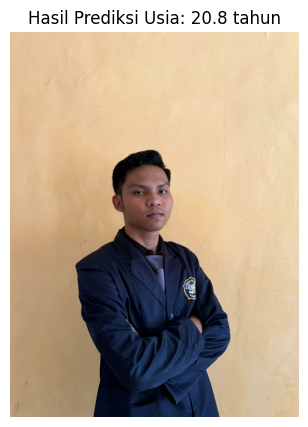

In [50]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# --- Pastikan model dari Praktikum D2 sudah dilatih dan ada di variabel 'model' ---

# Ganti dengan nama file foto Anda
nama_file_foto_pribadi = 'saya.JPG'
IMG_SIZE = 160  # Ukuran gambar harus sama dengan saat training (160x160)

try:
    # Muat dan siapkan gambar
    img_raw = tf.io.read_file(nama_file_foto_pribadi)
    img = tf.image.decode_jpeg(img_raw, channels=3)

    # Simpan gambar asli untuk ditampilkan (tidak di-resize)
    img_original = img.numpy().astype("uint8")

    # Resize hanya untuk model
    img_resized = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img_normalized = img_resized / 255.0
    img_expanded = tf.expand_dims(img_normalized, 0)

    # Prediksi
    # Use the 'model' variable from D2
    pred_age = model.predict(img_expanded, verbose=0).ravel()[0]

    # Tampilkan hasil (pakai gambar original)
    plt.figure(figsize=(5, 5))
    plt.imshow(img_original)
    plt.title(f"Hasil Prediksi Usia: {pred_age:.1f} tahun")
    plt.axis('off')
    plt.show()


except FileNotFoundError:
    print(f"Error: File '{nama_file_foto_pribadi}' tidak ditemukan. Mohon unggah terlebih dahulu.")
except Exception as e:
    print(f"Terjadi error: {e}")

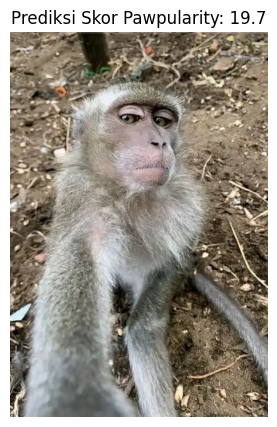

In [54]:
import tensorflow as tf
import matplotlib.pyplot as plt

# --- Pastikan model dari Praktikum D3 sudah dilatih dan ada di variabel 'model' ---

# Ganti dengan nama file foto hewan Anda
nama_file_foto_hewan = 'Monyet tamvan.jpeg'
IMG_SIZE = 224  # Ukuran input model (EfficientNet)

# Fungsi untuk memuat dan menyiapkan gambar untuk model
def prepare_image_for_model(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img

try:
    # Muat gambar asli (untuk ditampilkan)
    img_asli = tf.image.decode_jpeg(tf.io.read_file(nama_file_foto_hewan), channels=3)

    # Siapkan gambar untuk model
    img_tensor = prepare_image_for_model(nama_file_foto_hewan)
    img_expanded = tf.expand_dims(img_tensor, 0)  # Tambah dimensi batch

    # Prediksi skor
    pred_score = model.predict(img_expanded, verbose=0).ravel()[0]

    # Tampilkan hanya gambar asli
    plt.figure(figsize=(5, 5))
    plt.imshow(img_asli.numpy().astype("uint8"))
    plt.title(f"Prediksi Skor Pawpularity: {pred_score:.1f}")
    plt.axis('off')
    plt.show()

except FileNotFoundError:
    print(f"Error: File '{nama_file_foto_hewan}' tidak ditemukan. Mohon unggah terlebih dahulu.")
except Exception as e:
    print(f"Terjadi error: {e}")
